In [1]:
from PIL import Image
import numpy as np 
import torch 
import time
from resnet import * 

model = resnet18()
model.eval()

test_image = Image.open("iris.jpg")
tensor = torch.from_numpy(np.array(test_image))
reshaped = tensor.permute(2, 0, 1).unsqueeze(0)
inputs =  reshaped.float()
#print(inputs.size)
trace_jit = torch.jit.trace(model, inputs)

t = time.time()
y1 = trace_jit(inputs)
time_pytorch = time.time() - t 
print("Default version took {:.2f}ms".format(1000 *time_pytorch))

Default version took 99.64ms


In [3]:
import pytorch_tiramisu as pt 
pt.enable(jit=False) 


t = time.time()
generated = pt.compile(model(inputs))
compilation_time = time.time() - t

t = time.time()
pt.execute(generated)
execution_time = time.time() - t

print("Tiramisu compilation took {:.2f}ms".format(1000 * compilation_time)
print("Tiramisu execution took {:.2f}ms".format(1000 * execution_time))

Tiramisu compilation took 124.37ms
Tiramisu execution took 43.5ms


In [5]:
models = [resnet18(), resnet34(), resnet50(), resnet152()]

pytorch_times = []
for model in models:
    t = time.time()
    y = model(inputs)
    time_pytorch = time.time() - t
    pytorch_times.append(time_pytorch*1000)
    
pytorch_times

[56.0147762298584, 85.01696586608887, 161.14020347595215, 406.5890312194824]

In [6]:
tiramisu_times = []

for model in models:
    t = time.time()
    generated = pt.compile(model(inputs))
    compilation_time = time.time() - t

    t = time.time()
    pt.execute(generated)
    execution_time = time.time() - t
    tiramisu_times.append(execution_time*1000)

tiramisu_times

[43.2658584014776, 45.14020347608887, 103.21501692121949, 268.9865955890324]

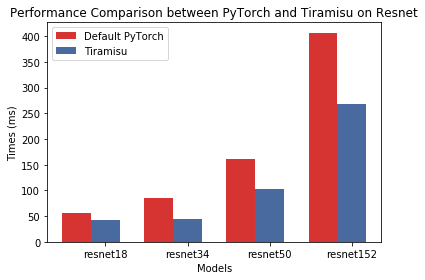

In [10]:
import numpy as np
import matplotlib.pyplot as plt

# data to plot
n_groups = len(models)
# create plot
fig, ax = plt.subplots()
index = np.arange(n_groups)
bar_width = 0.35
opacity = 0.8

rects1 = plt.bar(index, pytorch_times, bar_width,
alpha=opacity,
color='#cc0000',
label='Default PyTorch')

rects2 = plt.bar(index + bar_width, tiramisu_times, bar_width,
alpha=opacity,
color='#1c4587',
label='Tiramisu')

plt.xlabel('Models')
plt.ylabel('Times (ms)')
plt.title('Performance Comparison between PyTorch and Tiramisu on Resnet')
plt.xticks(index + bar_width, ('resnet18', 'resnet34', 'resnet50', 'resnet152'))
plt.legend()

plt.tight_layout()
plt.show()